In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from stop_words import get_stop_words
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from umap import UMAP
from collections import Counter

In [2]:
df = pd.read_csv('../dataset/movies_complete.csv')
df.dropna(subset=['genre'], inplace=True)
df['text_length'] = df.text.apply(lambda x: len(x.split()))
df = df[df['text_length'] >= 3000]

In [3]:
def aggregate_by_label(df: pd.DataFrame, label: str, min_threshold: int = 0):
    
    top_labels = df[label].value_counts()[df[label].value_counts() > min_threshold]
    
    entries = []
    for l in top_labels.index:
        label_df = df[df[label] == l]
        all_texts = []
        for text in label_df.text:
            all_texts.append(text)
        entry = {}
        
        conctanated_text = " ".join(all_texts)
        entry['label'] = l
        entry['text'] = conctanated_text
        entry['n_texts'] = len(all_texts)
        entry['n_tokens'] = len(conctanated_text.split())
        entry['instances'] = ", ".join(label_df.filename.to_list())
        
        entries.append(entry)
    return pd.DataFrame.from_records(entries)

In [4]:
def get_cluster_dfs(df, cluster):
    return[df[cluster == i] for i in np.unique(cluster)]

In [5]:
from plotly.colors import qualitative 

def plotly_color_categorical_values(values, cmap=qualitative.Light24):
    uniq = np.unique(values)
    if len(uniq) > len(cmap):
        print("Need more colors than current cmap holds")
        return
    categories_color = {cat: cmap[index] for index, cat in enumerate(uniq)}
    return [categories_color[cat] for cat in values]

In [36]:
aggr = aggregate_by_label(df, 'genre', 9)

In [65]:
Xr = UMAP(n_components=2, n_neighbors=20).fit_transform(X.todense())
#Xr = PCA(n_components=2).fit_transform(X.todense())

In [86]:
tfidf = TfidfVectorizer(
    #stop_words=get_stop_words('de'),
    max_features=20000)

X = tfidf.fit_transform(aggr.text)

In [66]:
fig = go.Figure(data=go.Scatter(x=Xr[:, 0],
                                y=Xr[:, 1],
                                mode='markers',
                                text=[f'{label}|{n_token}' for label, n_token in zip(aggr.label, aggr.n_texts)],
                                marker_color=aggr.n_tokens))


fig.show()

In [67]:
single_labels = aggr.label[aggr.label.str.split(',').apply(lambda x: len(x)) == 1]
n_single_labels = len(single_labels)
single_labels, n_single_labels

(0           Drama
 1          Comedy
 6          Horror
 11    Documentary
 13       Thriller
 18         Action
 30         Family
 64          Crime
 Name: label, dtype: object,
 8)

In [89]:
from sklearn.mixture import GaussianMixture

clu = GaussianMixture(n_components=n_single_labels)
Xpca = UMAP(n_components=70).fit_transform(X.todense())

cluster = clu.fit_predict(Xpca)
probs = clu.predict_proba(Xpca)

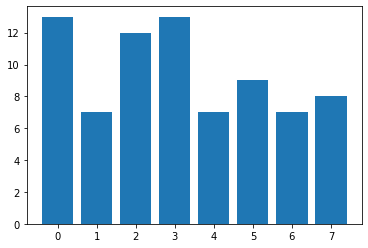

In [90]:
cluster_counter = Counter(cluster)
plt.bar(cluster_counter.keys(), cluster_counter.values())
plt.show()

In [91]:
fig = go.Figure(data=go.Scatter(x=Xr[:, 0],
                                y=Xr[:, 1],
                                mode='markers',
                                text=[f'{label}|{n_token}' for label, n_token in zip(aggr.label, aggr.n_texts)],
                                marker_color=plotly_color_categorical_values(cluster)))


fig.show()

In [71]:
dfs = get_cluster_dfs(aggr, cluster)

In [54]:
dfs[0].label

1                       Comedy
6                       Horror
8              Horror,Thriller
12        Crime,Drama,Thriller
13                    Thriller
16         Action,Comedy,Crime
18                      Action
19                 Crime,Drama
23     Action,Adventure,Comedy
25     Horror,Mystery,Thriller
26               Comedy,Horror
27          Comedy,Crime,Drama
29              Crime,Thriller
34               Action,Comedy
42        Action,Comedy,Horror
44    Adventure,Family,Fantasy
46      Adventure,Comedy,Drama
50                Comedy,Crime
58            Adventure,Family
64                       Crime
70            Adventure,Comedy
74               Horror,Sci-Fi
Name: label, dtype: object